In [ ]:
 pip install geostatspy

In [ ]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python

In [ ]:
import os                                               # to set current working directory
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting

In [ ]:
current_directory = os.getcwd()                                   # set the working directory
current_directory

'/content'

In [ ]:
df = pd.read_csv(current_directory+"/sample_data_MV_biased.csv")                     # read a .csv file in as a DataFrame
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,0,100.0,900.0,0.0,0.101319,1.996868,5590.417154
1,1,100.0,800.0,1.0,0.147676,10.711789,3470.845666
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513
3,3,100.0,600.0,1.0,0.186167,217.109365,3732.114787
4,4,100.0,500.0,1.0,0.146088,16.717367,2534.551236


In [ ]:
df.describe().transpose()                          # summary table of all facies combined DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,368.0,293.260870,169.058258,0.000000,150.500000,296.000000,439.500000,586.000000
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Facies,368.0,0.597826,0.491004,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,368.0,0.127026,0.030642,0.041122,0.103412,0.125842,0.148623,0.210258
Perm,368.0,85.617362,228.362654,0.094627,2.297348,10.377292,50.581288,1991.097723
AI,368.0,4791.736646,974.560569,1981.177309,4110.728374,4713.325533,5464.043562,7561.250336


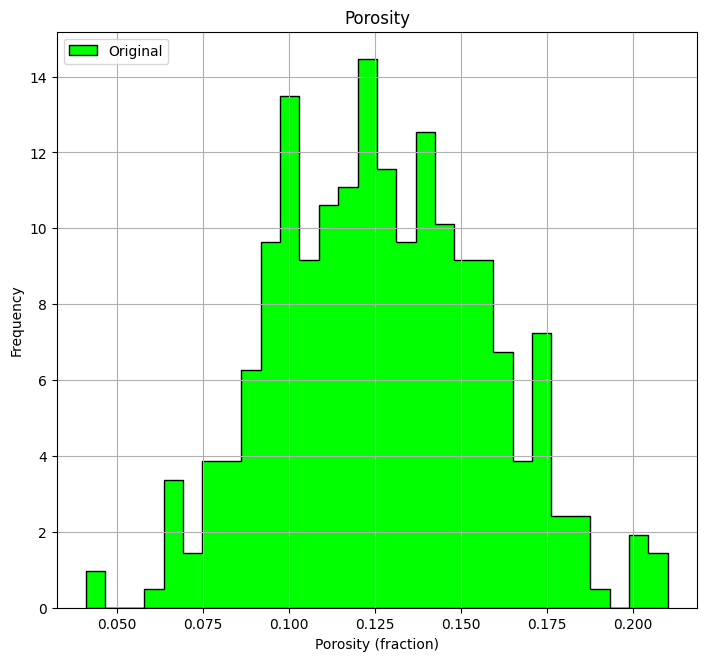

In [ ]:
plt.subplot(111)                                        # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='lime',bins=30,histtype="stepfilled",alpha=1,density=True,cumulative=False,edgecolor='black',label='Original')

plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

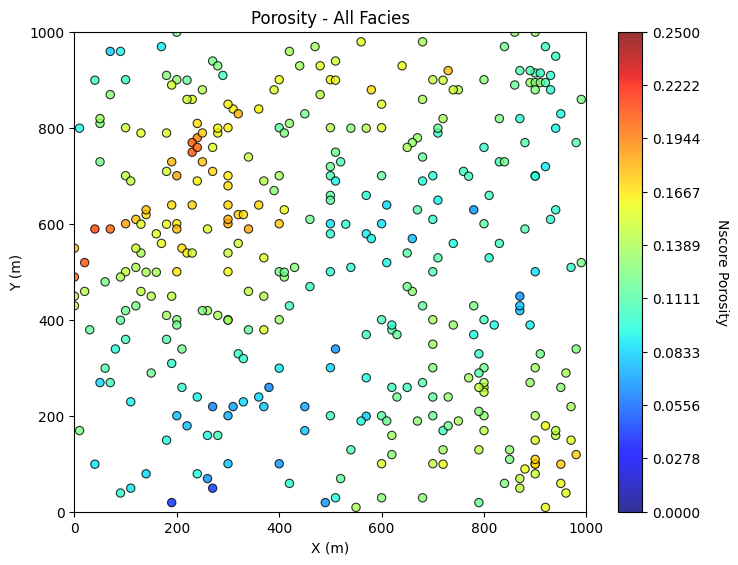

In [ ]:
cmap = plt.cm.jet                   # color map
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.5, hspace=0.3)
plt.show()

**Inverse Distance**

In [ ]:
import numpy as np
import scipy.spatial as sp

def invdist(df, xcol, ycol, vcol, tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power):
    """
    Inverse Distance to Python by Michael Pyrcz, the University of Texas at
    Austin (April, 2020). Based on modification of the GSLIB kb2d program by Deutsch and Journel (1997)

    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param power: the inverse distance power
    :return: estmap, an array with estimated values at each grid cell
    """

     # Constants
    UNEST = -999.
    EPSILON = 1.0e-10

    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]  # Trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax, nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

    # Allocate the needed memory:
    xa = np.zeros(ndmax)
    ya = np.zeros(ndmax)
    vra = np.zeros(ndmax)
    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax)
    s = np.zeros(ndmax)
    estmap = np.zeros((nx, ny))

     # Make a KDTree for fast search of nearest neighbors
    data_locs = np.column_stack((y, x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

    # Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()

    # Initialize accumulators
    rad2 = radius**2


     # MAIN LOOP OVER ALL THE BLOCKS IN THE GRID
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0, ny):
        yloc = ymn + (iy - 0) * ysiz
        for ix in range(0, nx):
            xloc = xmn + (ix - 0) * xsiz
            current_node = (yloc, xloc)

            # Find the nearest samples within each octant: First initialize the counter arrays
            na = -1  # Accounting for 0 as the first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node, ndmax)  # Use KD tree for fast nearest data search

              # Remove any data outside search radius
            nums = nums[dist < radius]
            dist = dist[dist < radius]
            nd = len(dist)

            # Is there enough samples?
            if nd < ndmin:  # Accounting for min index of 0
                est = UNEST
            else:
                # Put coordinates and values of neighborhood samples into xa, ya, vra
                for ia in range(0, nd):
                    jj = int(nums[ia])
                    xa[ia] = x[jj]
                    ya[ia] = y[jj]
                    vra[ia] = vr[jj]

                     # Solve for weights
                dist = np.sqrt((xa - xloc)**2 + (ya - yloc)**2)
                s = 1 / ((dist + EPSILON)**power)  # Calculate inverse weights
                s = s / np.sum(s)  # Constrain sum of the weights to 1.0 for unbiasedness
                est = 0.0
                for ia in range(0, nd):
                    est = est + s[ia] * vra[ia]

            estmap[ny - iy - 1, ix] = est

            # Track the estimates
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est**2

                 # END OF MAIN LOOP OVER ALL THE BLOCKS

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk / float(nk) - ak**2
        print('Estimated ' + str(nk) + ' blocks')
        print('Average ' + str(ak) + '  Variance ' + str(vk))

    return estmap



**Simple Test at Single Location**

Let's test the method for a single estimation location.

the result was validated with by-hand calculation for inside range, outside range and collocated with a data point

In [ ]:
x = [100,600,800]; y = [100,500,700]; vr = [1.0,2.0,3.0]
dftest1 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;
nx = 1; xsiz = 10.0; xmn = 500
ny = 1; ysiz = 10.0; ymn = 500
ndmin = 1; ndmax = 100
radius = 1000.0; power = 2

invdist_est = invdist(dftest1,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)
print('The single estimate at x = ' + str(xmn) + ', y = ' + str(ymn) + ' is ' + str(invdist_est[0][0]) + '.')

Estimated 1 blocks
Average 2.041214750542347  Variance 0.0
The single estimate at x = 500, y = 500 is 2.041214750542347.


Estimated 10000 blocks
Average 2.4785256874279527  Variance 0.18122365890746384
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218
Estimated 10000 blocks
Average 2.4893068152705276  Variance 0.7378534388298741


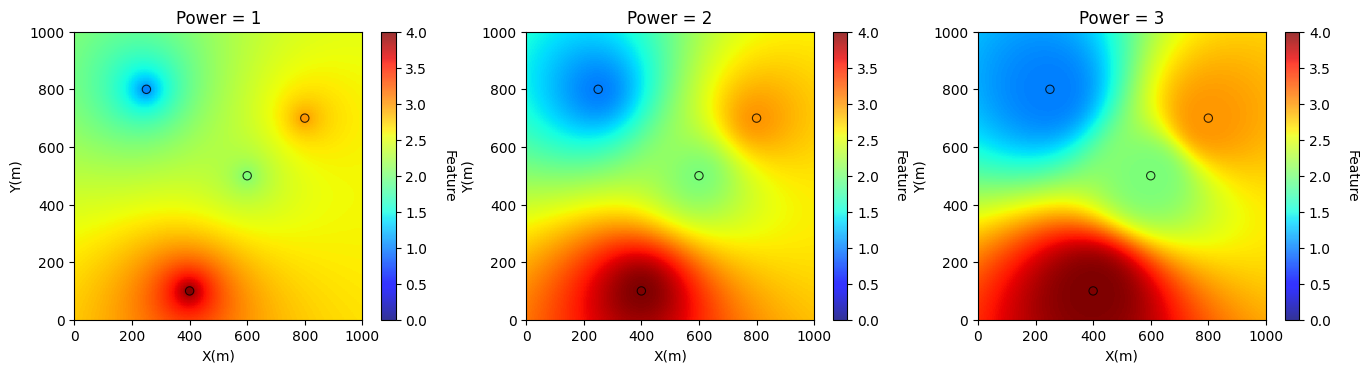

In [ ]:
x = [250,600,800,400]; y = [800,500,700,100]; vr = [1.0,2.0,3.0,4.0]
dftest2 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
radius = 10000.0; power = 2

invdist_map_power1 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=1)
invdist_map_power2 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=2)
invdist_map_power3 = invdist(dftest2,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=3)

# plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_power1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 1','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_power2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 2','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_power3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest2,'X','Y','Var','Power = 3','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)
plt.show()

Estimated 10000 blocks
Average 2.4785256874279527  Variance 0.18122365890746384
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218
Estimated 10000 blocks
Average 2.4893068152705276  Variance 0.7378534388298741


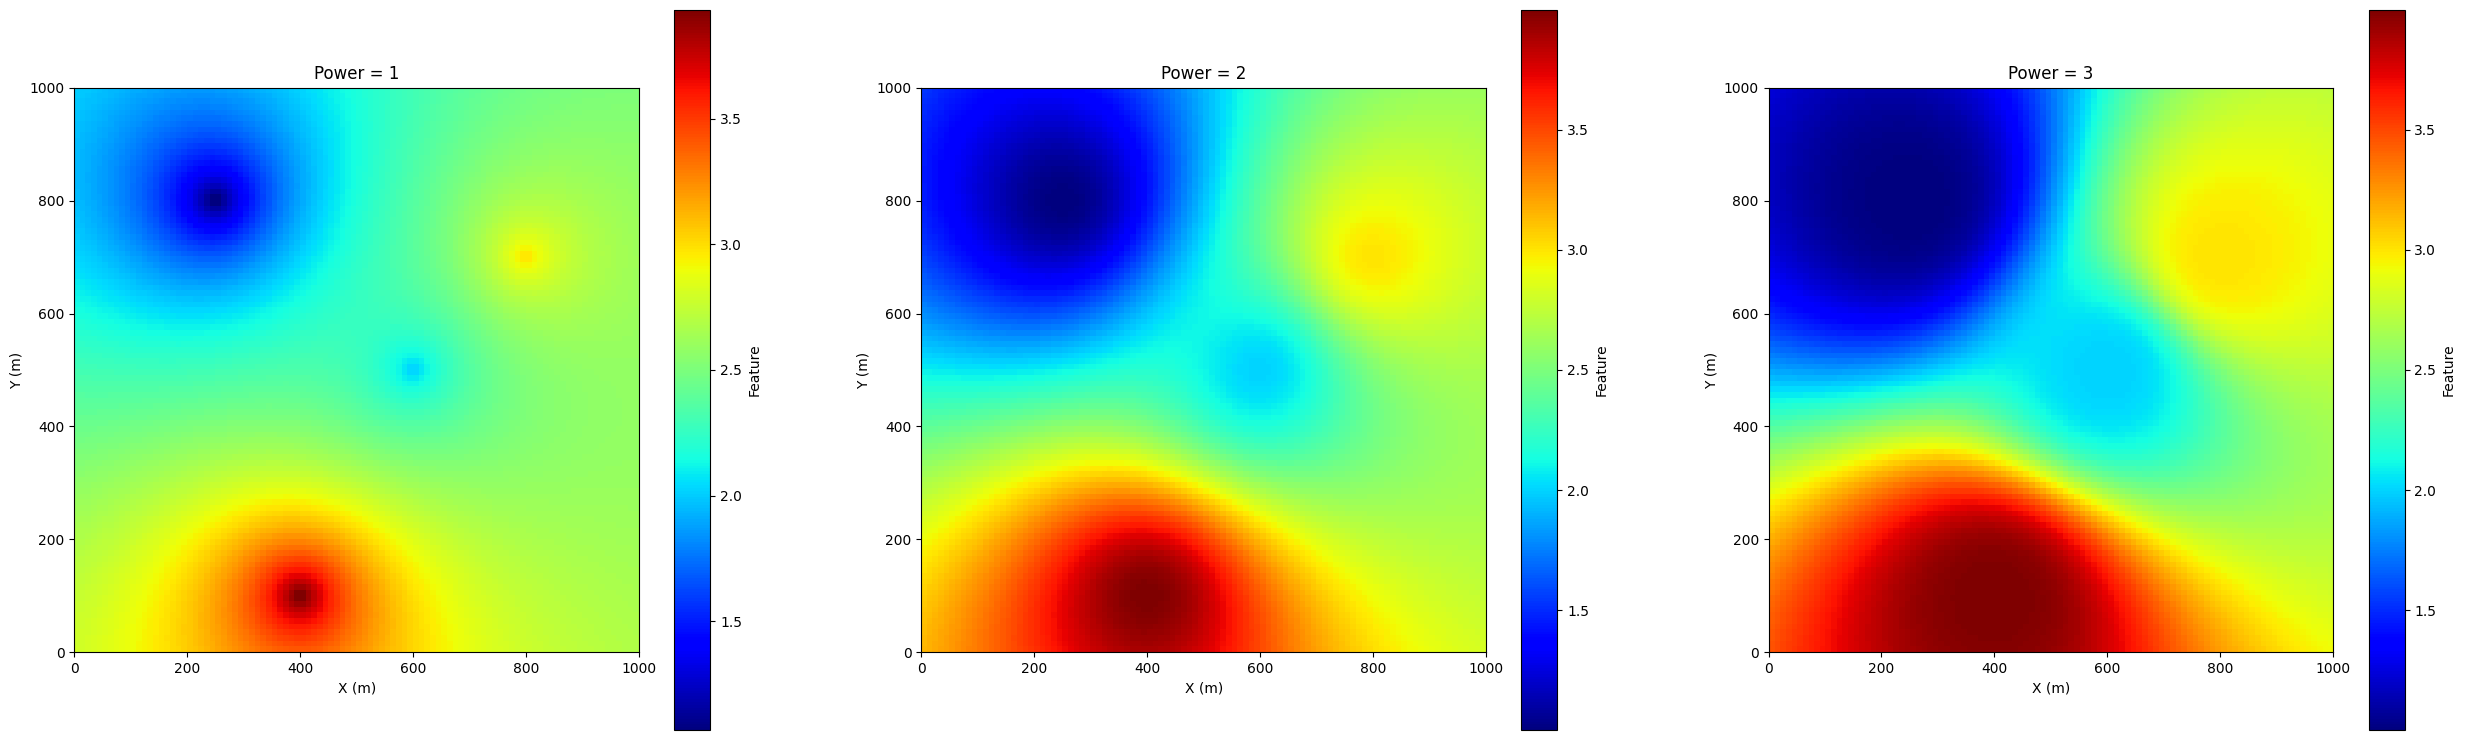

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the invdist function here

# Create the test DataFrame
x = [250, 600, 800, 400]
y = [800, 500, 700, 100]
vr = [1.0, 2.0, 3.0, 4.0]
dftest2 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 10000.0
power = 2

# Calculate the estimated maps with different power values
invdist_map_power1 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=1)
invdist_map_power2 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=2)
invdist_map_power3 = invdist(dftest2, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power=3)

# Plot the resulting estimated maps
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(invdist_map_power1, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 1')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
plt.imshow(invdist_map_power2, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 2')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
plt.imshow(invdist_map_power3, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Power = 3')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)
plt.show()



**Check Radius impact**

Estimated 1264 blocks
Average 2.39116744243245  Variance 1.049982892969484
Estimated 9852 blocks
Average 1.8721620915639599  Variance 0.7914133099779668
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218


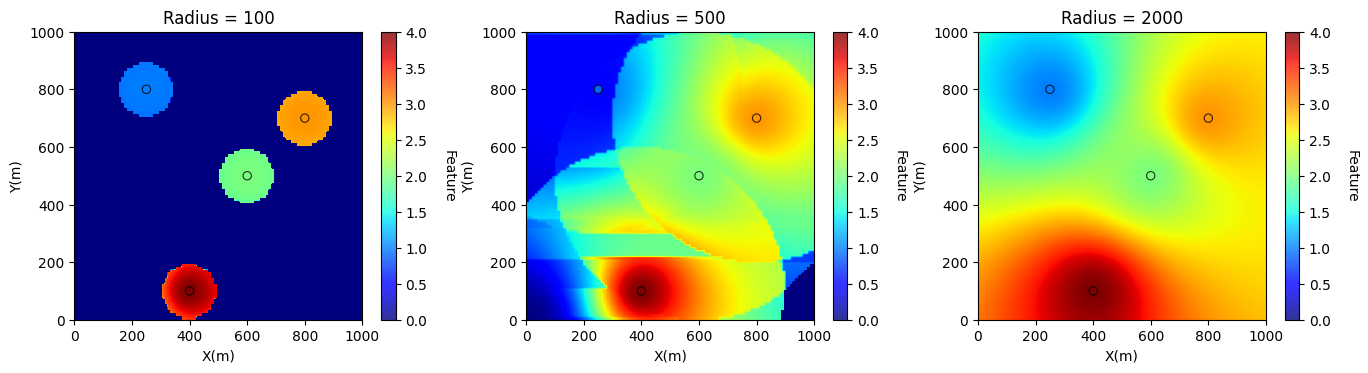

In [ ]:
x = [250,600,800,400]; y = [800,500,700,100]; vr = [1.0,2.0,3.0,4.0]
dftest3 = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
power = 2

invdist_map_radius1 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 100,power=2)
invdist_map_radius2 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 500,power=2)
invdist_map_radius3 = invdist(dftest3,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 2000,power=2)

# plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_radius1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 100','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_radius2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 500','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_radius3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest3,'X','Y','Var','Radius = 2000','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)
plt.show()

Estimated 1264 blocks
Average 2.39116744243245  Variance 1.049982892969484
Estimated 9852 blocks
Average 1.8721620915639599  Variance 0.7914133099779668
Estimated 10000 blocks
Average 2.4797288690464803  Variance 0.5062609912988218


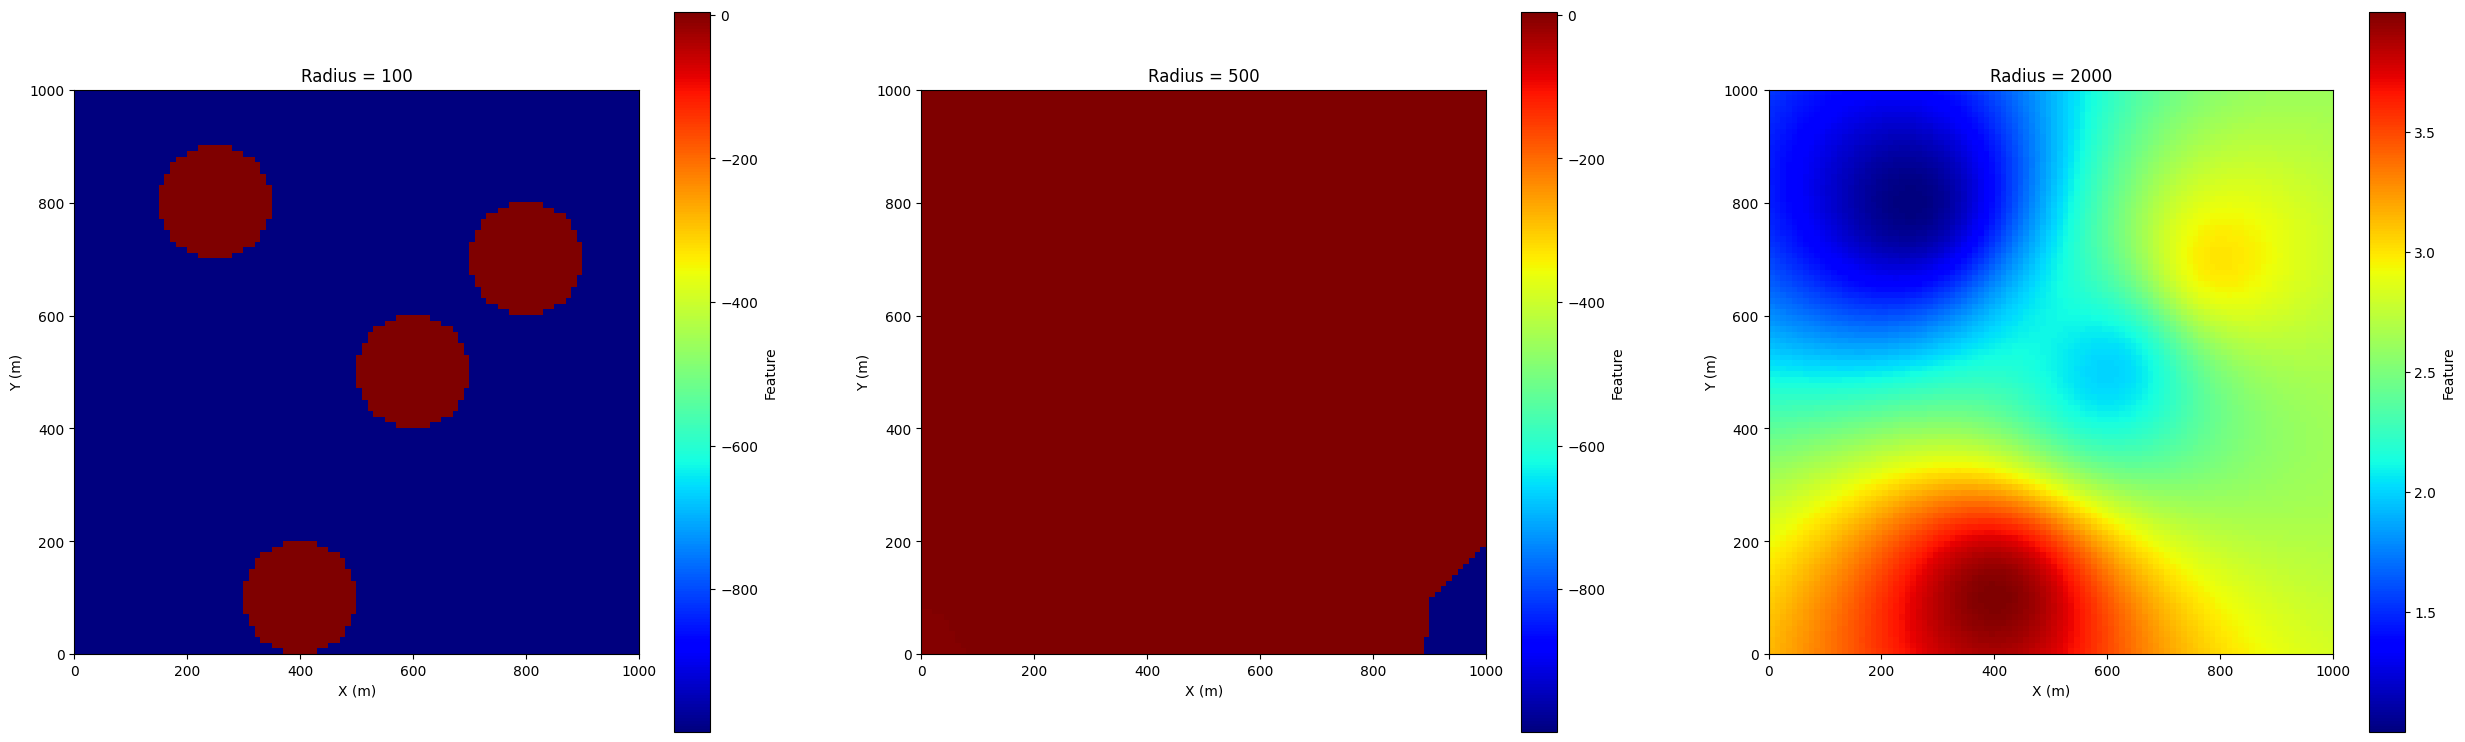

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the invdist function here

# Create the test DataFrame
x = [250, 600, 800, 400]
y = [800, 500, 700, 100]
vr = [1.0, 2.0, 3.0, 4.0]
dftest3 = pd.DataFrame({'X': x, 'Y': y, 'Var': vr})

# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
power = 2

# Calculate the estimated maps with different radii
invdist_map_radius1 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=100, power=2)
invdist_map_radius2 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=500, power=2)
invdist_map_radius3 = invdist(dftest3, 'X', 'Y', 'Var', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius=2000, power=2)

# Plot the resulting estimated maps
cmap = plt.get_cmap('jet')

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(invdist_map_radius1, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 100')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
plt.imshow(invdist_map_radius2, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 500')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
plt.imshow(invdist_map_radius3, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap=cmap)
plt.colorbar(label='Feature')
plt.title('Radius = 2000')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2)
plt.show()

**Inverse Distance Porosity Map**

Now we are ready to build a map of our porosity spatial feature.

-try experimenting with various powers and radii

Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098


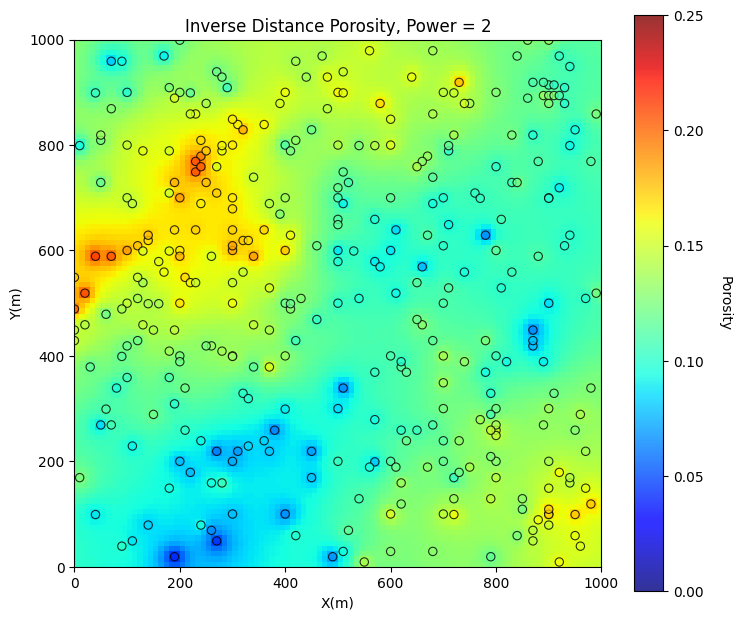

In [ ]:
tmin = -9999.9; tmax = 9999.9;
nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz
ndmin = 1; ndmax = 100
radius = 2000; power = 2

invdist_map_porosity = invdist(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)

# plot the reuslting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_porosity,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Inverse Distance Porosity, Power = ' + str(power),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098


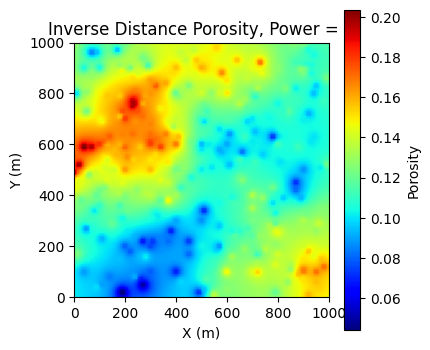

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
tmin = -9999.9
tmax = 9999.9
nx = 100
xsiz = 10.0
xmn = 5.0
xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz
ny = 100
ysiz = 10.0
ymn = 5.0
ymin = ymn - 0.5 * ysiz
ymax = ymin + ny * ysiz
ndmin = 1
ndmax = 100
radius = 2000
power = 2

# Calculate the estimated map
invdist_map_porosity = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)

# Plot the resulting estimated map
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(invdist_map_porosity, extent=[xmin, xmax, ymin, ymax], origin='upper', cmap='jet')
plt.colorbar(label='Porosity')
plt.title('Inverse Distance Porosity, Power = ' + str(power))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.2, hspace=0.2)
plt.show()


**Assignment**

**Question 1**

In [ ]:
import os

# Create directories if they don't exist
image_path = "image_path"
results_path = "results_path"

os.makedirs(image_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

**Question 2**

Saved PNG: image_path/porosity_histogram.png
Saved PDF: image_path/porosity_histogram.pdf


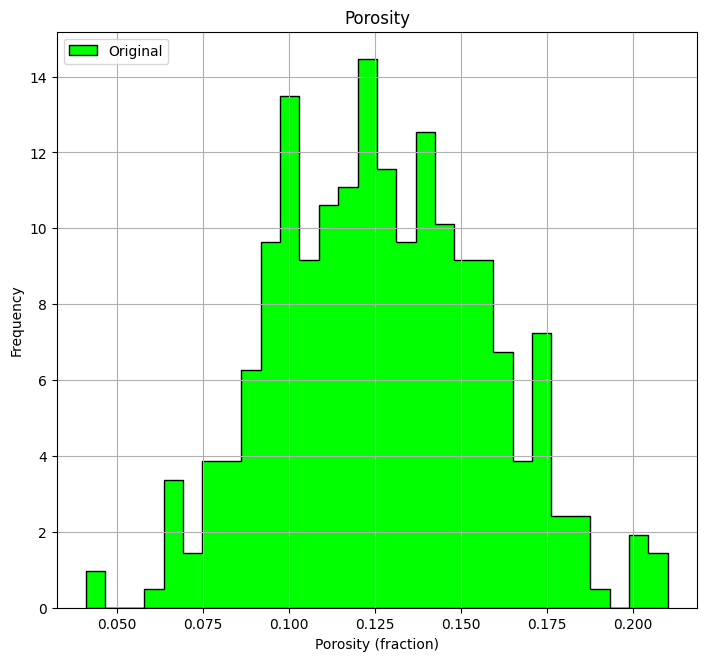

Saved PNG: image_path/locmap_st_plot.png
Saved PDF: image_path/locmap_st_plot.pdf


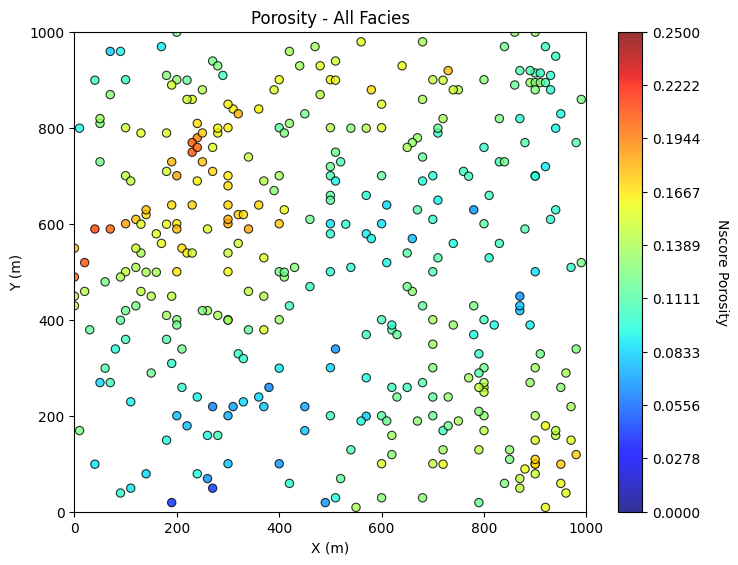

Saved PNG: image_path/invdist_power_1.png
Saved PDF: image_path/invdist_power_1.pdf


<Figure size 1200x1200 with 0 Axes>

Saved PNG: image_path/invdist_power_2.png
Saved PDF: image_path/invdist_power_2.pdf


<Figure size 1200x1200 with 0 Axes>

Saved PNG: image_path/invdist_radius_100.png
Saved PDF: image_path/invdist_radius_100.pdf


<Figure size 1200x1200 with 0 Axes>

In [ ]:
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages


image_path = "image_path"
results_path = "results_path"
os.makedirs(image_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)



def save_plots(fig, filename_prefix):
    # Save as PNG
    png_filename = os.path.join(image_path, f"{filename_prefix}.png")
    fig.savefig(png_filename, dpi=300, bbox_inches='tight')
    print(f"Saved PNG: {png_filename}")

    # Save as PDF
    pdf_filename = os.path.join(image_path, f"{filename_prefix}.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
    print(f"Saved PDF: {pdf_filename}")



plt.subplot(111)
plt.hist(df['Porosity'], facecolor='lime',bins=30,histtype="stepfilled",alpha=1,density=True,cumulative=False,edgecolor='black',label='Original')

plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)
fig = plt.gcf()
save_plots(fig, 'porosity_histogram')
plt.show()



cmap = plt.cm.jet
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.5, hspace=0.3)
fig = plt.gcf()
save_plots(fig, 'locmap_st_plot')
plt.show()


plt.figure(figsize=(12, 12))

fig = plt.gcf()
save_plots(fig, 'invdist_power_1')
plt.show()

plt.figure(figsize=(12, 12))

fig = plt.gcf()
save_plots(fig, 'invdist_power_2')
plt.show()



plt.figure(figsize=(12, 12))

fig = plt.gcf()
save_plots(fig, 'invdist_radius_100')
plt.show()



**Question 3**

In [ ]:

import os
import pandas as pd


os.makedirs("results", exist_ok=True)


power = 2
invdist_map_porosity_p2 = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)


x_coords = [xmn + i * xsiz for i in range(nx)] * ny
y_coords = [ymn + i * ysiz for i in range(ny)] * nx
porosity_values = invdist_map_porosity_p2.flatten()
df_p2 = pd.DataFrame({'X': x_coords, 'Y': y_coords, 'Porosity': porosity_values})
df_p2.to_csv(os.path.join("results", "idw_porosity_p2.csv"), index=False)


power = 3
invdist_map_porosity_p3 = invdist(df, 'X', 'Y', 'Porosity', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, ndmin, ndmax, radius, power)


x_coords = [xmn + i * xsiz for i in range(nx)] * ny
y_coords = [ymn + i * ysiz for i in range(ny)] * nx
porosity_values = invdist_map_porosity_p3.flatten()
df_p3 = pd.DataFrame({'X': x_coords, 'Y': y_coords, 'Porosity': porosity_values})
df_p3.to_csv(os.path.join("results", "idw_porosity_p3.csv"), index=False)

Estimated 10000 blocks
Average 0.12259182482534683  Variance 0.0005453274134406098
Estimated 10000 blocks
Average 0.12116877653698746  Variance 0.0007154759122327669


**Question 4**

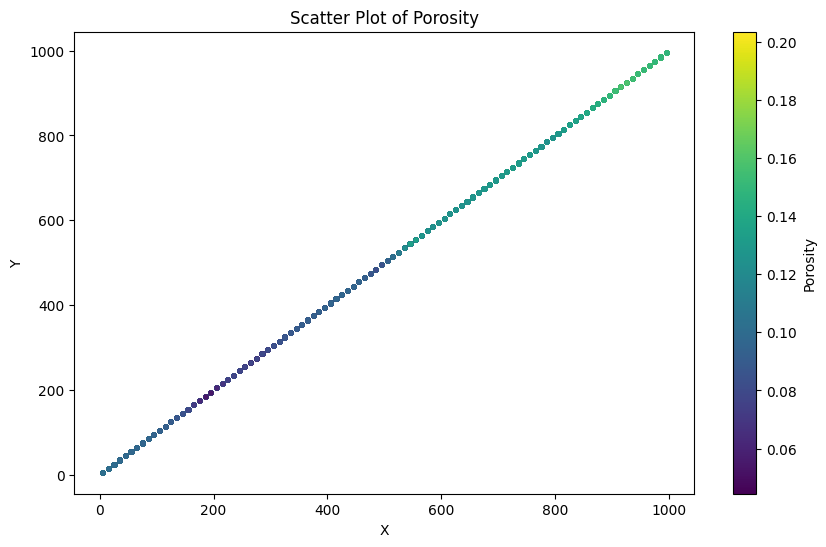

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import os


results_path = "results"
image_path = "image_path"


df_results = pd.read_csv(os.path.join(results_path, "idw_porosity_p2.csv"))


plt.figure(figsize=(10, 6))
plt.scatter(df_results['X'], df_results['Y'], c=df_results['Porosity'], marker='s', s=5, cmap='viridis')
plt.colorbar(label='Porosity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Porosity')

# Save the plot as PNG and PDF
plt.savefig(os.path.join(image_path, 'scatter_plot_porosity.png'))
plt.savefig(os.path.join(image_path, 'scatter_plot_porosity.pdf'))

plt.show()

**Question 7**

Kriging is generally more accurate than IDW (Inverse Distance Weighting) interpolation because it considers both distance and the relationship between data points, not just distance alone. While IDW relies on distance alone and can produce “bullseye” effects, especially at higher powers, Kriging uses a statistical model called a variogram to capture patterns in the data more precisely. This model helps Kriging make better predictions, especially when the data has clear spatial patterns or trends. So, if the data shows strong spatial relationships, Kriging is  the best choice for accurate and reliable interpolation.